# Group: Ivan Matoshchuk, David Neufeld

# Assignment 1

Hello dear students. You have successfully cloned the repo, great.
 - Exercise 0: Warm up tasks.
 - Exercise 1: Color spaces and morphological operators (Lecture 1)
 - Exercise 2: Convolution and Canny Edge detection (Lecture 2)

## Exercise 0 - Image-I/O

There are several python libraries for reading and displaying images. I recommend scikit-image. Execute the next cell and install missing libraries like scikit-image. 

In [19]:
# imports
%matplotlib inline
from skimage import io, data, color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

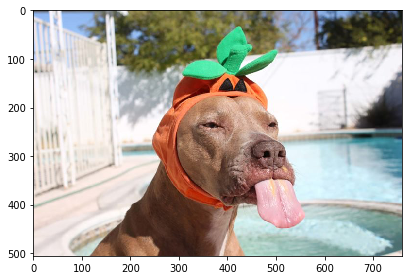

In [20]:
image = io.imread('images/dog.jpg')
io.imshow(image)

By the way, there are many test images in skimage.data that you can use for your tasks. Execute the next two cells. 

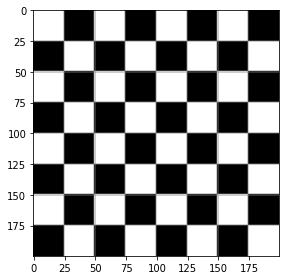

In [4]:
io.imshow(data.checkerboard())

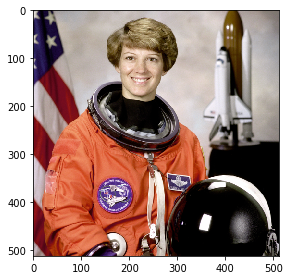

In [5]:
io.imshow(data.astronaut())

Add a line of code to the next cell to display 440 <= x <= 540 and 250 <= y <= 390 for the dog image!

In [6]:
image.shape

(506, 760, 3)

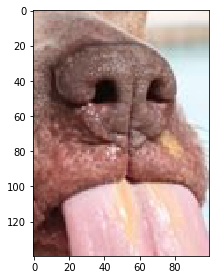

In [7]:
io.imshow(image[250:390,440:540,:])

Now convert the color image to a grayscale image and display it!

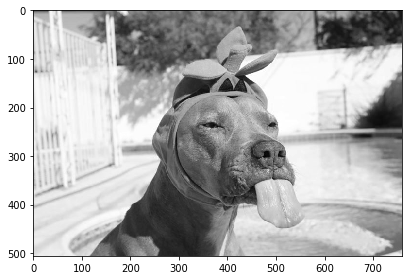

In [8]:
io.imshow(color.rgb2gray(image))

There are other color spaces. For example, HSV will be used in the lecture. Convert your image to HSV and display the H-channel.

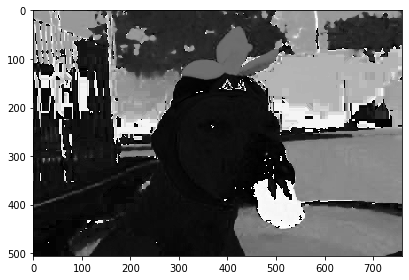

In [9]:
io.imshow(color.rgb2hsv(image)[...,0])

Did you know that HSV now allows creating robust (i.e. lighting independent) color histograms? Create one with Matplotlib!

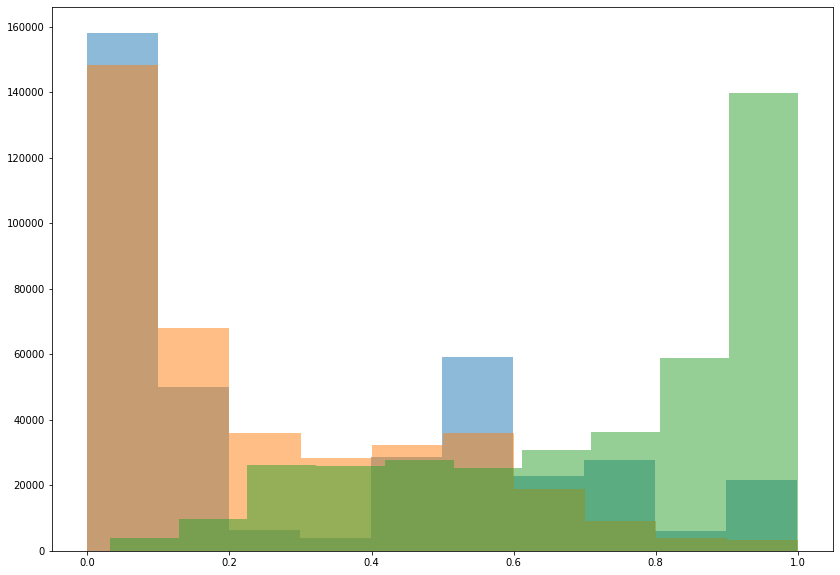

In [18]:
plt.figure(figsize = (14,10))
plt.hist(color.rgb2hsv(image)[...,0].flatten(), alpha= 0.5, label = "Hue")
plt.hist(color.rgb2hsv(image)[...,1].flatten(), alpha= 0.5, label = "Saturation")
plt.hist(color.rgb2hsv(image)[...,2].flatten(), alpha= 0.5, label = "Value")

plt.legend
plt.show()

## Exercise 1 - Color Spaces, Morphological Operators

### Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in `/images` and provided you with one in the next cell.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)

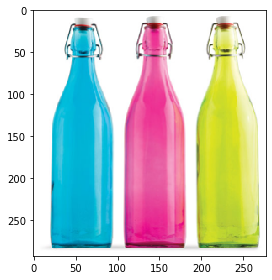

In [1060]:
image = io.imread('images/bottles.png')
io.imshow(image)

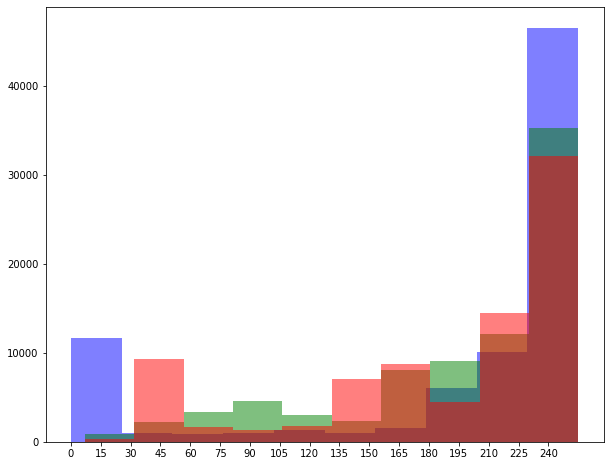

In [12]:
# plot color distribution
plt.figure(figsize = (10,8))
colors = ["b","g","r"]

for idx,i in enumerate(colors):
    plt.hist(image[...,idx].flatten(), color = i, alpha = 0.5)
    plt.xticks(range(0,255,15))
    
plt.show()


In [1074]:
def binarization(image: np.ndarray, mask : tuple, used_dim: int, description : str, plot : bool = True) -> np.ndarray:
    binarized_array = np.zeros_like(image)
    if used_dim == -1:
        binarized_array[mask[0], mask[1],:] = 255
    else:
        binarized_array[mask[0], mask[1],used_dim] = 255
    
    if plot:
        plt.imshow(binarized_array)
        plt.title(description)
    return binarized_array

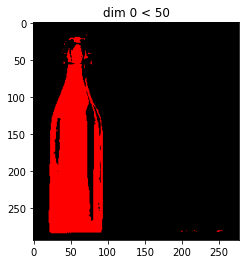

In [14]:
mask = np.where(image[...,0] < 50)
binarized_array = binarization(image, mask, used_dim = 0, description = "dim 0 < 50")

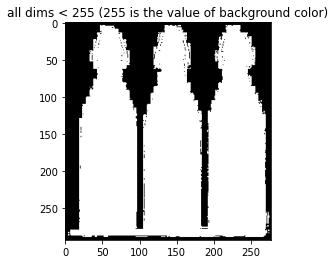

In [15]:
# all three bottles
mask = np.where((image < 255))
binarized_array = binarization(image, mask, used_dim = -1, description = "all dims < 255 (255 is the value of background color)")

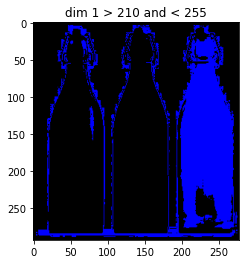

In [16]:
mask = np.where((image[...,1] > 210) & (image[...,1] < 255))
binarized_array = binarization(image, mask, used_dim = 2, description = "dim 1 > 210 and < 255")

In [17]:
# BGR ?

### Bottle in the center

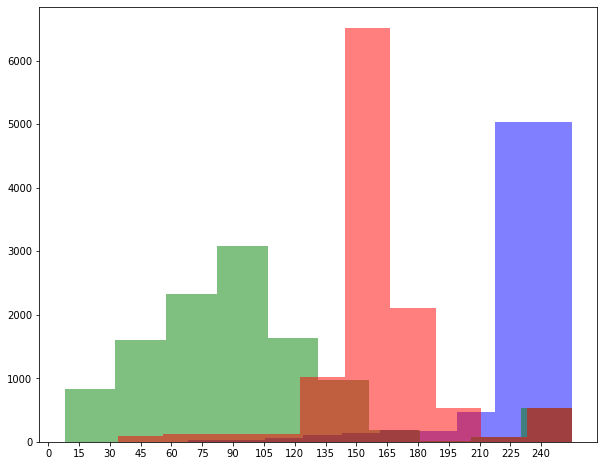

In [18]:
# plot color distribution of the center of the image (pink bottle)
plt.figure(figsize = (10,8))
colors = ["b","g","r"]

for idx,i in enumerate(colors):
    plt.hist(image[120:,110:175,:][...,idx].flatten(), color = i, alpha = 0.5)
    plt.xticks(range(0,255,15))
    
plt.show()


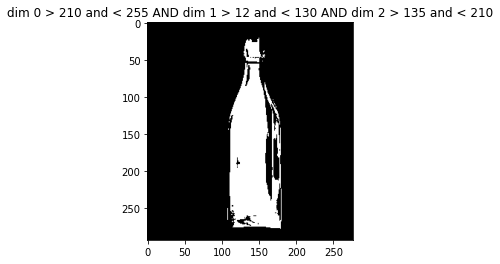

In [1061]:
mask = np.where(((image[...,0] > 210) & (image[...,0] < 255)) & ((image[...,1] > 12) & (image[...,1] < 130)) & ((image[...,2] > 135)&(image[...,2] < 210)))
binarized_array = binarization(image, mask, used_dim = -1, description = "dim 0 > 210 and < 255 AND dim 1 > 12 and < 130 AND dim 2 > 135 and < 210")

### Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

#### Test on array from lecture

In [295]:
input_array = np.array([[0,0,0,0,0],[0,1,1,0,0], [1,1,1,0,0], [0,1,0,0,0], [0,0,0,0,0]])
print(input_array)

[[0 0 0 0 0]
 [0 1 1 0 0]
 [1 1 1 0 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]


In [296]:
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
print(kernel)

[[0 1 0]
 [1 1 1]
 [0 1 0]]


In [300]:
from tqdm.notebook import tqdm

def set_steps(input_array_side_size: int, kernel_side_size: int) -> int:
    if (input_array_side_size - kernel_side_size) % 2 != 0:
        return input_array_side_size - kernel_side_size
    else:
        return input_array_side_size - kernel_side_size + 1

def apply_morphological_operators(input_array: np.ndarray, kernel: np.ndarray, pixel_value: int = 255, method: str = "dilate") -> np.ndarray:
    
    kernel_size = kernel.shape[0]
    
    output_array = np.copy(input_array)

    if input_array.shape[0] % 2 != 0:
        print("padded input array")
        input_array = np.pad(input_array,1)

    steps_height = set_steps(input_array.shape[0], kernel.shape[0])
    steps_width = set_steps(input_array.shape[1],kernel.shape[1])


    for i in tqdm(range(steps_height)):
        for j in range(steps_width):      
            #print(input_array[i:kernel_size + i,j:kernel_size + j])
            try:
                if method == "dilate":
                    if len(np.where((input_array[i:kernel_size + i,j:kernel_size + j] == kernel) & ( input_array[i:kernel_size + i,j:kernel_size + j] == pixel_value))[0]) > 0:
                        output_array[i,j] = pixel_value
                elif method == "erode":
                    if len(np.where((input_array[i:kernel_size + i,j:kernel_size + j] == kernel) & ( input_array[i:kernel_size + i,j:kernel_size + j] == pixel_value))[0]) == len(np.where(kernel != 0)[0]):
                        output_array[i,j] = pixel_value
                    else:
                        output_array[i,j] = 0
            except IndexError as e:
                print(e)

    return output_array
            

input_array = np.array([[0,0,0,0,0],[0,1,1,0,0], [1,1,1,0,0], [0,1,0,0,0], [0,0,0,0,0]])

output_array_dilate = apply_morphological_operators(input_array, kernel,pixel_value = 1, method = "dilate")
output_array_erode = apply_morphological_operators(input_array, kernel, pixel_value = 1, method = "erode")
                
                

padded input array


  0%|          | 0/5 [00:00<?, ?it/s]

padded input array


  0%|          | 0/5 [00:00<?, ?it/s]

In [301]:
output_array_dilate

array([[0, 1, 1, 0, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0],
       [0, 1, 0, 0, 0]])

In [302]:
output_array_erode

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [201]:
binarized_array = binarized_array[...,0]
output_array_dilate = apply_morphological_operators(binarized_array, kernel = np.full((3,3), 255),pixel_value = 255, method = "dilate")
output_array_erode = apply_morphological_operators(binarized_array, kernel = np.full((3,3), 255),pixel_value = 255, method = "erode")

padded input array


  0%|          | 0/293 [00:00<?, ?it/s]

padded input array


  0%|          | 0/293 [00:00<?, ?it/s]

padded input array


  0%|          | 0/293 [00:00<?, ?it/s]

Text(0.5, 1.0, 'dilate after erode image')

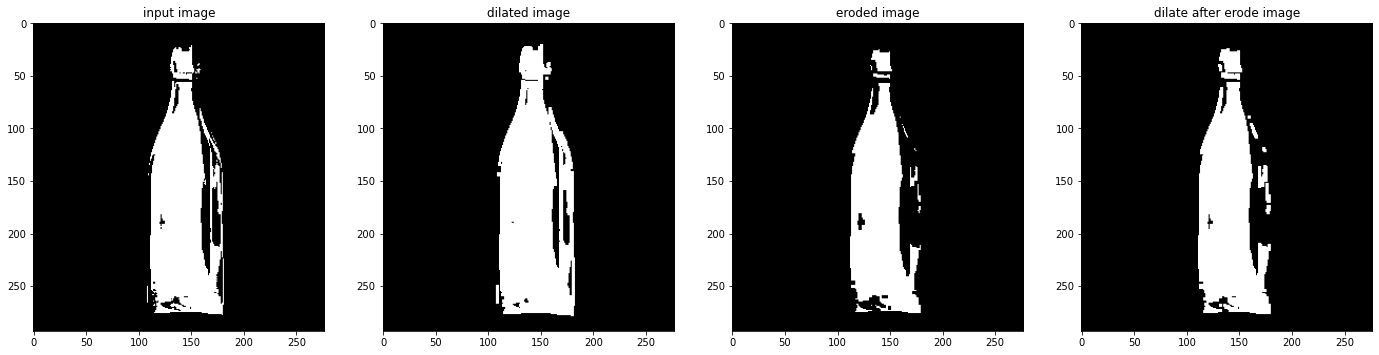

In [205]:
fig, ax = plt.subplots(1,4, figsize = (24,8))

ax[0].imshow(binarized_array, cmap = "gray")
ax[0].set_title("input image")

ax[1].imshow(output_array_dilate, cmap = "gray")
ax[1].set_title("dilated image")

ax[2].imshow(output_array_erode, cmap = "gray")
ax[2].set_title("eroded image")

ax[3].imshow(apply_morphological_operators(output_array_erode, kernel = np.full((3,3), 255),pixel_value = 255, method = "dilate"), cmap = "gray")
ax[3].set_title("dilate after erode image")



## Connected components

#### Test on array from lecture

[[0 1 0]
 [1 1 1]
 [0 1 0]] 

[[0 0 0 0 0]
 [0 1 0 1 0]
 [1 1 1 1 0]
 [0 1 0 0 0]
 [0 0 0 0 0]]


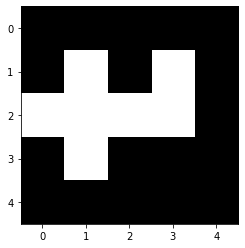

In [911]:
kernel = np.array([[0,1,0],[1,1,1],[0,1,0]])
print(kernel,"\n")

input_array = np.array([[0,0,0,0,0],[0,1,0,1,0], [1,1,1,1,0], [0,1,0,0,0], [0,0,0,0,0]])
print(input_array)
plt.imshow(input_array, cmap = 'gray')

In [912]:
input_array

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [913]:
input_array = np.array([[0,0,0,0,0],[0,1,0,1,0], [1,1,1,1,0], [0,1,0,0,0], [0,0,0,0,0]])
input_array

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [496]:
output_array = np.zeros_like(input_array)
output_array

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

### First pass

In [580]:
# 4-neghborhood

def first_pass(input_array: np.ndarray) -> np.ndarray:
    
    # init output_array with values = 0 and same shape as input
    output_array = np.zeros_like(input_array)
    
    # pas input_array with zeroes
    input_array = np.pad(input_array,1)

    label = 1

    for i in tqdm(range(1,input_array.shape[0])):
        for j in range(1,input_array.shape[1]):

            # skip if background
            if input_array[i,j] == 0:
                
                continue

            else:
                # if current_pixel == both_pixels(west and north) 
                if (input_array[i,j] == input_array[i,j - 1]) & (input_array[i, j] == input_array[i-1,j]):

                    # if their labels are equal assign it to new pixel
                    if output_array[i-1,j-2] == output_array[i-2,j-1]:
                        output_array[i-1,j-1] = output_array[i-1,j-2]
                    else:
                        # assign minimum of west vs north pixels
                        output_array[i-1,j-1] = min(output_array[i-1,j-2],  output_array[i-2,j-1])

                # if current_pixel == pixel_to_the_west then assign its value
                elif input_array[i,j] == input_array[i,j - 1]:
                    # output_array[i-1,j-1] = label
                    output_array[i-1,j-1] = output_array[i-1,j-2]

                # if current_pixel == pixel_to_the_north then assign its value
                elif input_array[i, j] == input_array[i-1,j]:
                    output_array[i-1,j-1] = output_array[i-2,j-1]

                else:
                    output_array[i-1,j-1] = label
                    label += 1
    return output_array


        
        
        

In [498]:
output_array = first_pass(input_array)
output_array

  0%|          | 0/6 [00:00<?, ?it/s]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 2, 0],
       [3, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

### Second pass

In [502]:

def second_pass(input_array: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    
    kernel_size = kernel.shape[0]
    
    output_2d_pass = np.copy(input_array)
    input_array = np.pad(input_array,1)



    steps_height = set_steps(input_array.shape[0], kernel.shape[0])
    steps_width = set_steps(input_array.shape[1],kernel.shape[1])

    for i in tqdm(range(steps_height)):
        for j in range(steps_width):

            not_background = np.where((input_array[i:kernel_size+i,j:kernel_size+j]!=0) & (kernel !=0))
            if len(not_background[0]) > 0:
                unique_labels_in_window = np.unique(input_array[i:kernel_size+i,j:kernel_size+j])
                label = min(unique_labels_in_window[unique_labels_in_window!=0])


                output_2d_pass[i:kernel_size+i,j:kernel_size+j][output_2d_pass[i:kernel_size+i,j:kernel_size+j] != 0 ] = label
            
    return output_2d_pass

In [503]:
output_2d_pass = second_pass(output_array, kernel)
output_2d_pass

  0%|          | 0/5 [00:00<?, ?it/s]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

### One-pass

In [1019]:

def one_pass(input_array: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    
    kernel_size = kernel.shape[0]
    
    output_1_pass = np.zeros_like(input_array)

    input_array = np.pad(input_array,1)
    


    steps_height = set_steps(input_array.shape[0], kernel.shape[0])
    steps_width = set_steps(input_array.shape[1],kernel.shape[1])
    label = 1
    for i in tqdm(range(steps_height)):
        for j in range(steps_width):

            not_background = np.where((input_array[i:kernel_size+i,j:kernel_size+j]!=0) & (kernel !=0))
            if len(not_background[0]) > 0:
                # check neighborhood , if some pixels are labeled, take their label
                unique_labels_in_window = np.unique(output_1_pass[i + not_background[0] - 1, j + not_background[1]-1])

                if len(unique_labels_in_window[unique_labels_in_window!=0]) < 1:

                    output_1_pass[i + not_background[0] - 1, j + not_background[1]-1] = label
                    label += 1
                else:
                    label_in_window = min(unique_labels_in_window[unique_labels_in_window!=0])
                    
                    output_1_pass[i + not_background[0] - 1, j + not_background[1]-1] = label_in_window

    # relable sequentially
    for idx,i in enumerate(np.unique(output_1_pass)):
        output_1_pass[np.where(output_1_pass == i)] = idx
            
    return output_1_pass

In [1020]:
output_1_pass = one_pass(input_array, kernel = np.ones((3,3)))
output_1_pass

  0%|          | 0/5 [00:00<?, ?it/s]

array([[0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0],
       [1, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [547]:
output_binarized_array_1st_pass = first_pass(binarized_array)


  0%|          | 0/294 [00:00<?, ?it/s]

In [548]:
output_binarized_array_2d_pass = second_pass(output_binarized_array_1st_pass, kernel)



  0%|          | 0/293 [00:00<?, ?it/s]

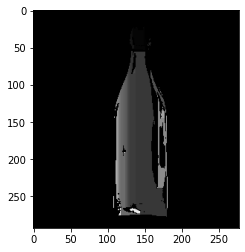

In [549]:
plt.imshow(output_binarized_array_2d_pass, cmap = 'gray')

  0%|          | 0/293 [00:00<?, ?it/s]

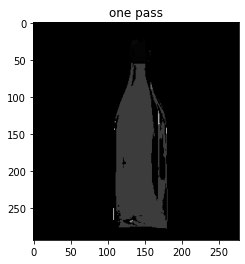

In [1014]:
plt.imshow(one_pass(binarized_array, kernel = np.full((3,3),1)), cmap = 'gray')
plt.title("one pass")
plt.show()

#### baseline, opencv-python

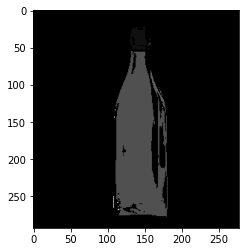

In [734]:
import cv2

num_labels, labels = cv2.connectedComponents(binarized_array)

plt.imshow(labels, cmap = 'gray')

### Extract bounding box

padded input array


  0%|          | 0/287 [00:00<?, ?it/s]

/tmp/ipykernel_13169/3385474689.py:28: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if len(np.where((input_array[i:kernel_size + i,j:kernel_size + j] == kernel) & ( input_array[i:kernel_size + i,j:kernel_size + j] == pixel_value))[0]) > 0:


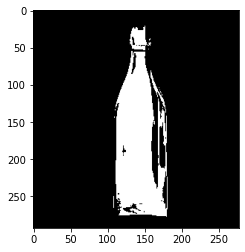

In [ ]:
# dilate with large kernel to make a solide picture
binarized_array_dilated = apply_morphological_operators(binarized_array, kernel = np.full((8,8), 1),pixel_value = 1, method = "dilate")

plt.imshow(binarized_array_dilated , cmap = 'gray')

In [1067]:
# bounding box over dilated image

def draw_bbox(input_image : np.ndarray, over_label: int = -1, return_only_bbox : bool = False) -> np.ndarray:
    

    output_image = np.copy(input_image)
    labels = np.unique(input_image)

    # draw over particular label
    if over_label != -1:
        labels = [0,over_label]
        

    for i in tqdm(labels[1::]):
        indices = np.where(input_image == i)

        top = max(indices[0])
        left = min(indices[1])
        bottom = min(indices[0])
        right = max(indices[1])

        # create dummy dataframe to simulate bounding box

        # if straight line
        if (right - left) == 0:
            # if just 1 pixel - skip it
            try:
                dummy_bbox = np.ones( (3, top-bottom+1)) - np.pad(np.ones((1 , top-bottom -1 )),1)
            except ValueError:
                continue
        else:
            dummy_bbox = np.ones( (right-left +1, top-bottom+1)) - np.pad(np.ones((right-left -1 , top-bottom -1 )),1)


        # indices of bbox
        indices = np.where(dummy_bbox == 1)


        # draw bbox
        output_image[indices[1] + bottom, indices[0] + left] = i 
        
    # return bbox if not all labels selected (used in tracking later)
    if return_only_bbox and over_label != -1:
        only_bbox = np.zeros_like(input_image)
        only_bbox[indices[1] + bottom, indices[0] + left] = over_label
        return only_bbox
    
    return output_image



  0%|          | 0/1 [00:00<?, ?it/s]

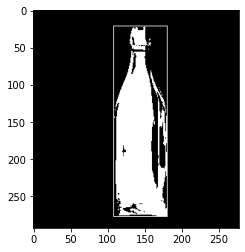

In [1064]:
image_with_bbox = draw_bbox(binarized_array_dilated)


# # Map component labels to hue val
# label_hue = np.uint8(179*image_with_bbox/np.max(image_with_bbox))
# blank_ch = 255*np.ones_like(label_hue)

# labeled_img = np.transpose(np.stack([label_hue, blank_ch, blank_ch]), (1,2,0))

# labeled_img = color.hsv2rgb(labeled_img)
# # set background label to black
# labeled_img[label_hue==0] = 0

plt.imshow(image_with_bbox)


  0%|          | 0/13 [00:00<?, ?it/s]

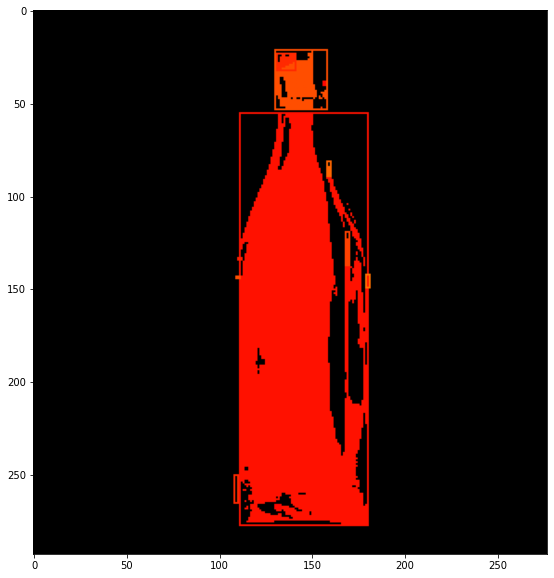

In [1036]:
# draw bboxes after one-pass algorithm
image_with_bbox = draw_bbox(output_1_pass)


# Map component labels to hue val
label_hue = np.uint8(179*image_with_bbox/np.max(image_with_bbox))
blank_ch = 255*np.ones_like(label_hue)

labeled_img = np.transpose(np.stack([label_hue, blank_ch, blank_ch]), (1,2,0))

labeled_img = color.hsv2rgb(labeled_img)
# set background label to black
labeled_img[label_hue==0] = 0

plt.figure(figsize=(10,10))
plt.imshow(labeled_img)


### Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

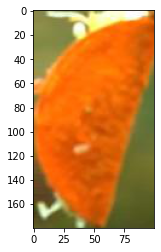

In [1037]:
image = io.imread("images/taco/010.jpg")
#plt.imshow(image)
plt.imshow(image[170:350,0:100])

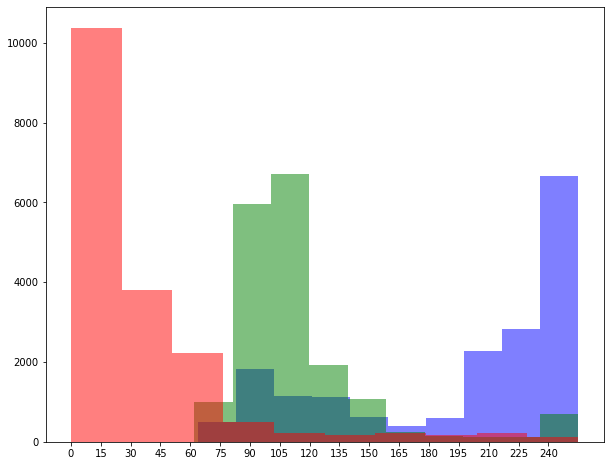

In [844]:
# plot color distribution
plt.figure(figsize = (10,8))
colors = ["b","g","r"]

for idx,i in enumerate(colors):
    plt.hist(image[170:350,0:100,idx].flatten(), color = i, alpha = 0.5)
    plt.xticks(range(0,255,15))
    
plt.show()


In [1139]:
def find_taco_label(input_array: np.ndarray) -> int:
    """
    we assume that after finding connected components based on our color threshold
    the "taco=label" will be most-represented ( will have highest number of pixels ) 
    """
    label_sizes = []
    # omit background
    for label in np.unique(input_array)[1:]:
        label_sizes.append(np.sum(one_pass_taco == label))
    return np.argmax(label_sizes) + 1

In [1228]:
image.shape

(480, 854, 3)

In [ ]:
import os

path_to_taco = os.path.join("images","taco")

bboxes = []

for i in tqdm(os.listdir(path_to_taco)):
    path_to_image = os.path.join(path_to_taco, i)
    image = io.imread(path_to_image)
    
    # get taco
    mask = np.where(((image[...,0] > 180) & (image[...,0] <255)) & ((image[...,1] > 80) & (image[...,1] < 135)) & ((image[...,2] > 0)&(image[...,2] < 75)))
    binarized_array = binarization(image, mask, used_dim = -1, description = "dim 0 > 180 and < 255 AND dim 1 > 80 and < 135 AND dim 2 > 0 and < 75", plot = False)
    
    # dilate with large kernel to make a solide view of taco
    binarized_array_dilated = apply_morphological_operators(binarized_array[...,0], kernel = np.full((5,5), 1),pixel_value = 1, method = "dilate")
    
    # find connected components
    one_pass_taco = one_pass(binarized_array_dilated, kernel = np.full((5,5), 1))
    
    # get taco label
    taco_label = find_taco_label(one_pass_taco)
    
    # get bbox
    only_bbox = draw_bbox(one_pass_taco, over_label = taco_label, return_only_bbox=True)

    bboxes.append(only_bbox)
    

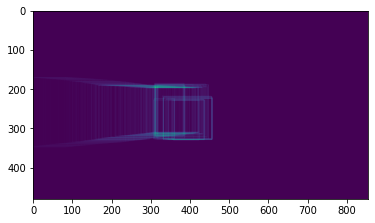

In [1147]:
plt.imshow(sum(bboxes))

In [1230]:
import pickle
with open("tracking_tacko2.pickle", "wb") as f:
    pickle.dump( bboxes, f)

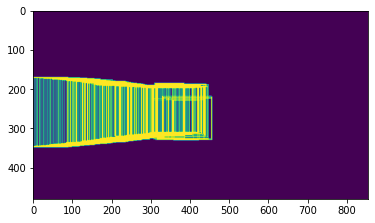

In [1150]:
test = sum(bboxes)
test = np.where(test!=0,255,0)
plt.imshow(test)

In [1229]:
# create video
import cv2

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')

video = cv2.VideoWriter("flying_taco_video.avi", fourcc, 10, (854, 480), isColor=True)


for idx, i in tqdm(enumerate(os.listdir(path_to_taco))):
    path_to_image = os.path.join(path_to_taco, i)
    image = cv2.imread(path_to_image)
    
    sub_bbox = bboxes[idx]
    
    image[...,0][np.where(sub_bbox != 0)] = 255
    image[...,1:][np.where(sub_bbox != 0)] = 0 
    
    video.write(image)
     


0it [00:00, ?it/s]

In [ ]:
# Video is here:
https://github.com/IvanMatoshchuk/cv2122_assignments/blob/dev-ivan/flying_taco_video.mp4

In [3]:
from IPython.display import Video, HTML

Video("flying_taco_video.mp4", embed=True)

### Exercise 1.4 (BONUS)

* find connected components using a one-pass algorithm
* plot the resulting image and compare it to the result of your two-pass implementation (**RESULT**)

In [1235]:
# implemented above
# here is it once again:

def one_pass(input_array: np.ndarray, kernel: np.ndarray) -> np.ndarray:
    
    kernel_size = kernel.shape[0]
    
    output_1_pass = np.zeros_like(input_array)

    input_array = np.pad(input_array,1)
    


    steps_height = set_steps(input_array.shape[0], kernel.shape[0])
    steps_width = set_steps(input_array.shape[1],kernel.shape[1])
    label = 1
    for i in tqdm(range(steps_height)):
        for j in range(steps_width):

            not_background = np.where((input_array[i:kernel_size+i,j:kernel_size+j]!=0) & (kernel !=0))
            if len(not_background[0]) > 0:
                # check neighborhood , if some pixels are labeled, take their label
                unique_labels_in_window = np.unique(output_1_pass[i + not_background[0] - 1, j + not_background[1]-1])

                if len(unique_labels_in_window[unique_labels_in_window!=0]) < 1:

                    output_1_pass[i + not_background[0] - 1, j + not_background[1]-1] = label
                    label += 1
                else:
                    label_in_window = min(unique_labels_in_window[unique_labels_in_window!=0])
                    
                    output_1_pass[i + not_background[0] - 1, j + not_background[1]-1] = label_in_window

    # relable sequentially
    for idx,i in enumerate(np.unique(output_1_pass)):
        output_1_pass[np.where(output_1_pass == i)] = idx
            
    return output_1_pass

## Exercise 2: Convolution and Canny edge detection

### Exercise 2.1: Convolution
Implement the convolution operation for 2-D images (i.e. no colors here, sorry).

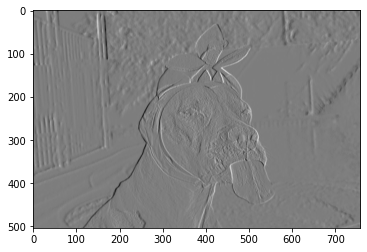

In [24]:
def conv2d(image, kernel):
    m, n = kernel.shape
    if (m == n):
        y, x = image.shape
        y = y - m + 1
        x = x - m + 1
        new_image = np.zeros((y,x))
    for i in range(y):
        for j in range(x):
            new_image[i][j] = np.sum(image[i:i+m, j:j+m]*kernel)
    return new_image

image = color.rgb2gray(io.imread('images/dog.jpg'))
plt.imshow(conv2d(image, np.array([[-1,0,1],[-1,0,1],[-1,0,1]])), cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***).

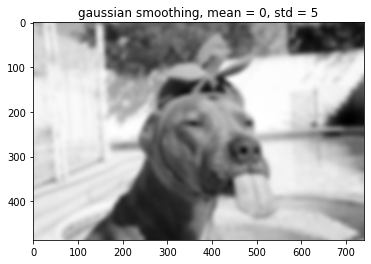

In [42]:
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)


def gaussian_kernel(size, sigma=1, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D
kernel = gaussian_kernel(20,5)
plt.imshow(conv2d(image, kernel), cmap='gray')
plt.title("gaussian smoothing, mean = 0, std = 5")
plt.show()



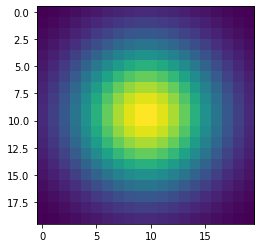

In [43]:
plt.imshow(kernel)

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

Text(0.5, 1.0, 'without smoothing')

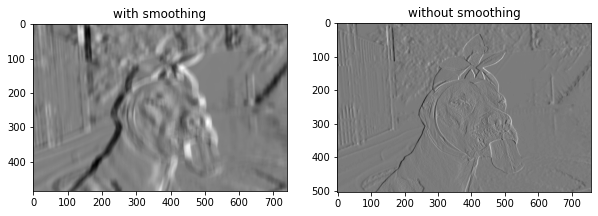

In [48]:
filter_kernel = np.array([[-1,0,1],
          [-2,0,2],
          [-1,0,1]])

with_gaus = conv2d(conv2d(image, kernel), filter_kernel)
without_gaus = conv2d(image, filter_kernel)

fig, ax = plt.subplots(1,2, figsize = (10,6))

ax[0].imshow(with_gaus, cmap = 'gray')
ax[0].set_title('with smoothing')

ax[1].imshow(without_gaus, cmap = 'gray')
ax[1].set_title('without smoothing')


### Exercise 2.2: Canny Edge Detection

#### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!

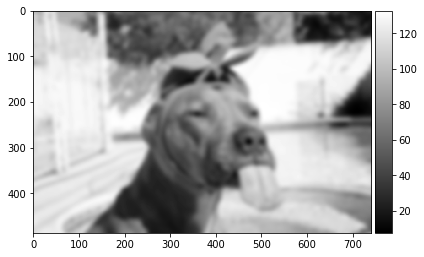

In [50]:
# Smooth the image with a Gaussian

kernel = gaussian_kernel(20,5)
image_conv = conv2d(image, kernel)

io.imshow(image_conv, cmap = 'gray')

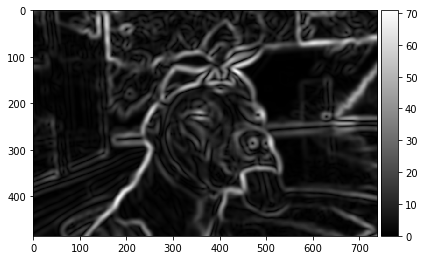

In [53]:
filter_kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
new_image_x = conv2d(image_conv, filter_kernel)
new_image_y = conv2d(image_conv,np.transpose(filter_kernel))
gradient_magnitude = np.sqrt(np.square(new_image_x) + np.square(new_image_y))

io.imshow(gradient_magnitude, cmap = 'gray')
theta = np.arctan2(new_image_y, new_image_x)

#### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

In [54]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

Text(0.5, 1.0, 'non-max suppression')

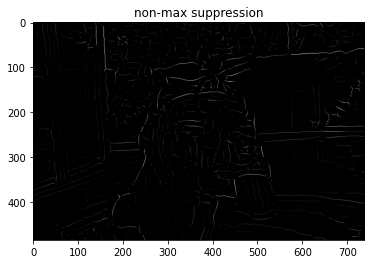

In [56]:
image_nms = non_max_suppression(gradient_magnitude, theta)
plt.imshow(image_nms, cmap='gray')
plt.title("non-max suppression")

#### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)

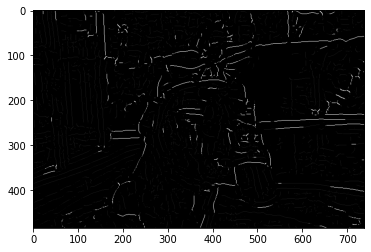

In [ ]:
def threshold(img, threshold_low_ratio=0.1, threshold_top_ratio=0.15):
    
    threshold_top_boundary = img.max() * threshold_top_ratio;
    threshold_low_boundary = threshold_top_ratio * threshold_low_ratio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= threshold_top_boundary)
    zeros_i, zeros_j = np.where(img < threshold_low_boundary)
    
    weak_i, weak_j = np.where((img <= threshold_top_boundary) & (img >= threshold_low_boundary))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

(image_nms_thres, w, s) = threshold(image_nms, threshold_low_ratio = 0.12, threshold_top_ratio = 0.25)
plt.imshow(image_nms_thres, cmap='gray')

### Congratz, you made it! You can now try to solve this optional exercise.

This exercise is not graded, but might be a good preparation for the exam.

Please go to the following link: https://forms.gle/wMNmbTu1sAAWQz8d8.

In the form, you will find the optional task (and the corresponding consent form in case you agree with us processing your data). The task is formulated in German, and we would prefer German as the language for your answer. However, if you don’t feel comfortable with that, please feel free to solve it in English.


